# Few-Shot Learning With Prototypical Networks

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
import multiprocessing as mp
tqdm.pandas(desc="my bar!")
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import scipy.io
# print(os.listdir("../input"))
from sklearn.model_selection import train_test_split
# Any results you write to the current directory are saved as output.

## Data Reading and Augmentation
The Omniglot data set is designed for developing more human-like learning algorithms. It contains 1623 different handwritten characters from 50 different alphabets. Then to increase the number of classes, all the images are rotated by 90, 180 and 270 degrees and each rotation resulted in one more class. Hence the total count of classes reached to 6492(1623 * 4) classes. We split images of 4200 classes to training data and the rest went to test set.

In [2]:
# train_dir = os.listdir('../input/omniglot/images_background/')
# datax = np.array([])

In [3]:
# def image_rotate(img, angle):
#     """
#     Image rotation at certain angle. It is used for data augmentation
#     """
#     rows,cols, _ = img.shape
#     M = cv2.getRotationMatrix2D((cols/2 ,rows/2),angle,1)
#     dst = cv2.warpAffine(img,M,(cols,rows))
#     return np.expand_dims(dst, 0)

# def read_alphabets(alphabet_directory, directory):
#     """
#     Reads all the characters from alphabet_directory and augment each image with 90, 180, 270 degrees of rotation.
#     """
#     datax = None
#     datay = []
#     characters = os.listdir(alphabet_directory)
#     for character in characters:
#         images = os.listdir(alphabet_directory + character + '/')
#         for img in images:
#             image = cv2.resize(cv2.imread(alphabet_directory + character + '/' + img), (28,28))
#             # image90 = image_rotate(image, 90)
#             # image180 = image_rotate(image, 180)
#             # image270 = image_rotate(image, 270)
#             image = np.expand_dims(image, 0)
#             if datax is None:
#                 datax = np.vstack([image])
#             else:
#                 datax = np.vstack([datax, image])
#             datay.append(directory + '_' + character + '_0')
#             datay.append(directory + '_' + character + '_90')
#             datay.append(directory + '_' + character + '_180')
#             datay.append(directory + '_' + character + '_270')
#     return datax, np.array(datay)

# def read_images(base_directory):
#     """
#     Used multithreading for data reading to decrease the reading time drastically
#     """
#     datax = None
#     datay = []
#     pool = mp.Pool(mp.cpu_count())
#     results = [pool.apply(read_alphabets, args=(base_directory + '/' + directory + '/', directory, )) for directory in os.listdir(base_directory)]
#     pool.close()
#     for result in results:
#         if datax is None:
#             datax = result[0]
#             datay = result[1]
#         else:
#             datax = np.vstack([datax, result[0]])
#             datay = np.concatenate([datay, result[1]])
#     return datax, datay

In [4]:
# %time trainx, trainy = read_images('../input/omniglot/images_background/')

In [5]:
# %time testx, testy = read_images('../input/omniglot/images_evaluation/')

In [6]:
# trainx.shape, trainy.shape, testx.shape, testy.shape

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
csv_path="/content/drive/MyDrive/Capstone MDD/PsyMRI data - all versions/Nooshin - DPARSF(V4-3) from DPABI/new_csv_file_subject_info.csv"
data_path="/content/drive/MyDrive/Capstone MDD/PsyMRI data - all versions/Nooshin - DPARSF(V4-3) from DPABI/Nooshin Schaefer -400/zTransformed_Connectivity_matrices"

In [9]:
def read_data():
  label_file=pd.read_csv(csv_path)
  label_file['group'] = label_file['group'].replace({'Controls': False, 'Patients': True})
  label_file = label_file[label_file['site'] == 'PsyMRI_FoGr']
  data=[]
  labels=[]
  for index, row in label_file.iterrows():
    id=row['ID']
    path=data_path+f'/Schaef400_ROICorrelation_FisherZ_{id}.mat'
    patient_data = scipy.io.loadmat(path)
    patient_features = patient_data['v']
    nan_indices_train = np.argwhere(np.isnan(patient_features))
    if len(nan_indices_train) > 0:
      print(id, "++++++++++++++++", sep=" ")
      continue
    label=row['group']
    data.append(patient_features)
    labels.append(label)
  data=np.array(data)
  labels=np.array(labels)
  return data, labels

In [10]:
data, labels=read_data()

MSFoGr_017 ++++++++++++++++


In [11]:
data.shape, labels.shape

((197, 79800, 1), (197,))

In [12]:
trainx, testx, trainy, testy = train_test_split(data, labels, test_size=0.2, random_state=42)

In [13]:

trainx.shape, trainy.shape, testx.shape, testy.shape

((157, 79800, 1), (157,), (40, 79800, 1), (40,))

In [14]:
trainy=trainy.ravel()
testy=testy.ravel()


## Model

In [15]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
use_gpu = torch.cuda.is_available()

In [16]:
trainx = torch.from_numpy(trainx).float()
#trainy = torch.from_numpy(trainy)
testx = torch.from_numpy(testx).float()
#testy = torch.from_numpy(testy)
if use_gpu:
    trainx = trainx.cuda()
    testx = testx.cuda()
trainx.size(), testx.size()

(torch.Size([157, 79800, 1]), torch.Size([40, 79800, 1]))

In [17]:
trainx = trainx.permute(0,2,1)
testx = testx.permute(0,2,1)

In [18]:
trainx.size(), testx.size()

(torch.Size([157, 1, 79800]), torch.Size([40, 1, 79800]))

In [19]:
class Net(nn.Module):
    """
    Image2Vector CNN which takes image of dimension (28x28x3) and return column vector length 64
    """
    def sub_block(self, in_channels, out_channels=64, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv1d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
                    torch.nn.BatchNorm1d(out_channels),
                    torch.nn.ReLU(),
                    torch.nn.MaxPool1d(kernel_size=2),
                    # torch.nn.Dropout(0.2)
                )
        return block

    def __init__(self):
        super(Net, self).__init__()
        self.convnet1 = self.sub_block(1)
        self.convnet2 = self.sub_block(64)
        self.convnet3 = self.sub_block(64)
        self.convnet4 = self.sub_block(64)

    def forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        x = self.convnet4(x)
        x = torch.flatten(x, start_dim=1)
        return x

In [20]:
class PrototypicalNet(nn.Module):
    def __init__(self, use_gpu=False):
        super(PrototypicalNet, self).__init__()
        self.f = Net()
        self.gpu = use_gpu
        if self.gpu:
            self.f = self.f.cuda()

    def forward(self, datax, datay, Ns,Nc, Nq, total_classes):
        """
        Implementation of one episode in Prototypical Net
        datax: Training images
        datay: Corresponding labels of datax
        Nc: Number  of classes per episode
        Ns: Number of support data per class
        Nq:  Number of query data per class
        total_classes: Total classes in training set
        """
        k = total_classes.shape[0]
        K = np.random.choice(total_classes, Nc, replace=False)
        Query_x = torch.Tensor()
        if(self.gpu):
            Query_x = Query_x.cuda()
        Query_y = []
        Query_y_count = []
        centroid_per_class  = {}
        class_label = {}
        label_encoding = 0
        for cls in K:
            S_cls, Q_cls = self.random_sample_cls(datax, datay, Ns, Nq, cls)
            centroid_per_class[cls] = self.get_centroid(S_cls, Nc)
            class_label[cls] = label_encoding
            label_encoding += 1
            Query_x = torch.cat((Query_x, Q_cls), 0) # Joining all the query set together
            Query_y += [cls]
            Query_y_count += [Q_cls.shape[0]]
        Query_y, Query_y_labels = self.get_query_y(Query_y, Query_y_count, class_label)
        Query_x = self.get_query_x(Query_x, centroid_per_class, Query_y_labels)
        return Query_x, Query_y

    def random_sample_cls(self, datax, datay, Ns, Nq, cls):
        """
        Randomly samples Ns examples as support set and Nq as Query set
        """
        data = datax[(datay == cls).nonzero()]
        perm = torch.randperm(data.shape[0])
        idx = perm[:Ns]
        S_cls = data[idx]
        idx = perm[Ns : Ns+Nq]
        Q_cls = data[idx]
        if self.gpu:
            S_cls = S_cls.cuda()
            Q_cls = Q_cls.cuda()
        return S_cls, Q_cls

    def get_centroid(self, S_cls, Nc):
        """
        Returns a centroid vector of support set for a class
        """
        return torch.sum(self.f(S_cls), 0).unsqueeze(1).transpose(0,1) / Nc

    def get_query_y(self, Qy, Qyc, class_label):
        """
        Returns labeled representation of classes of Query set and a list of labels.
        """
        labels = []
        m = len(Qy)
        for i in range(m):
            labels += [Qy[i]] * Qyc[i]
        labels = np.array(labels).reshape(len(labels),)
        label_encoder = LabelEncoder()
        Query_y = torch.Tensor(label_encoder.fit_transform(labels).astype(int)).long()
        if self.gpu:
            Query_y = Query_y.cuda()
        Query_y_labels = np.unique(labels)
        return Query_y, Query_y_labels

    def get_centroid_matrix(self, centroid_per_class, Query_y_labels):
        """
        Returns the centroid matrix where each column is a centroid of a class.
        """
        centroid_matrix = torch.Tensor()
        if(self.gpu):
            centroid_matrix = centroid_matrix.cuda()
        for label in Query_y_labels:
            centroid_matrix = torch.cat((centroid_matrix, centroid_per_class[label]))
        if self.gpu:
            centroid_matrix = centroid_matrix.cuda()
        return centroid_matrix

    def get_query_x(self, Query_x, centroid_per_class, Query_y_labels):
        """
        Returns distance matrix from each Query image to each centroid.
        """
        centroid_matrix = self.get_centroid_matrix(centroid_per_class, Query_y_labels)
        Query_x = self.f(Query_x)
        m = Query_x.size(0)
        n = centroid_matrix.size(0)
        # The below expressions expand both the matrices such that they become compatible to each other in order to caclulate L2 distance.
        centroid_matrix = centroid_matrix.expand(m, centroid_matrix.size(0), centroid_matrix.size(1)) # Expanding centroid matrix to "m".
        Query_matrix = Query_x.expand(n, Query_x.size(0), Query_x.size(1)).transpose(0,1) # Expanding Query matrix "n" times
        Qx = torch.pairwise_distance(centroid_matrix.transpose(1,2), Query_matrix.transpose(1,2))
        return Qx

In [23]:
protonet = PrototypicalNet(use_gpu=use_gpu)
optimizer = optim.SGD(protonet.parameters(), lr = 0.001, momentum=0.7)

In [24]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


## Training

In [25]:
def train_step(datax, datay, Ns,Nc, Nq):
    optimizer.zero_grad()
    Qx, Qy= protonet(datax, datay, Ns, Nc, Nq, np.unique(datay))
    pred = torch.log_softmax(Qx, dim=-1)
    loss = F.nll_loss(pred, Qy)
    loss.backward()
    optimizer.step()
    acc = torch.mean((torch.argmax(pred, 1) == Qy).float())
    return loss, acc

In [26]:
num_episode = 16000
frame_size = 1000

In [27]:
frame_loss = 0
frame_acc = 0
for i in range(num_episode):
    loss, acc = train_step(trainx, trainy, 5, 2, 5)
    train_losses.append(loss.data.cpu().numpy())
    train_accuracies.append(acc.data.cpu().numpy())
    frame_loss += loss.data
    frame_acc += acc.data
    if( (i+1) % frame_size == 0):
        print("Frame Number:", ((i+1) // frame_size), 'Frame Loss: ', frame_loss.data.cpu().numpy().tolist()/ frame_size, 'Frame Accuracy:', (frame_acc.data.cpu().numpy().tolist() * 100) / frame_size)
        frame_loss = 0
        frame_acc = 0

Frame Number: 1 Frame Loss:  1.2452955322265624 Frame Accuracy: 73.43004760742187
Frame Number: 2 Frame Loss:  0.06855326843261719 Frame Accuracy: 97.73004150390625
Frame Number: 3 Frame Loss:  0.01222318458557129 Frame Accuracy: 99.72000732421876
Frame Number: 4 Frame Loss:  0.003816905498504639 Frame Accuracy: 99.9699951171875
Frame Number: 5 Frame Loss:  0.002196134567260742 Frame Accuracy: 100.0
Frame Number: 6 Frame Loss:  0.00171596360206604 Frame Accuracy: 100.0
Frame Number: 7 Frame Loss:  0.0017312754392623901 Frame Accuracy: 99.99000244140625
Frame Number: 8 Frame Loss:  0.001455302596092224 Frame Accuracy: 100.0
Frame Number: 9 Frame Loss:  0.0014369837045669555 Frame Accuracy: 99.99000244140625
Frame Number: 10 Frame Loss:  0.0009266250729560852 Frame Accuracy: 100.0
Frame Number: 11 Frame Loss:  0.0011170289516448974 Frame Accuracy: 100.0
Frame Number: 12 Frame Loss:  0.0009193231463432313 Frame Accuracy: 100.0
Frame Number: 13 Frame Loss:  0.0007472745180130005 Frame Accu

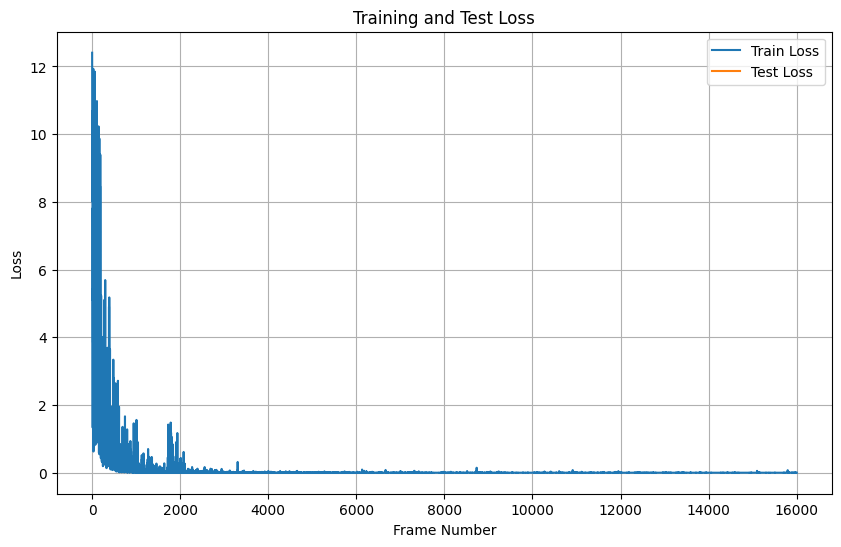

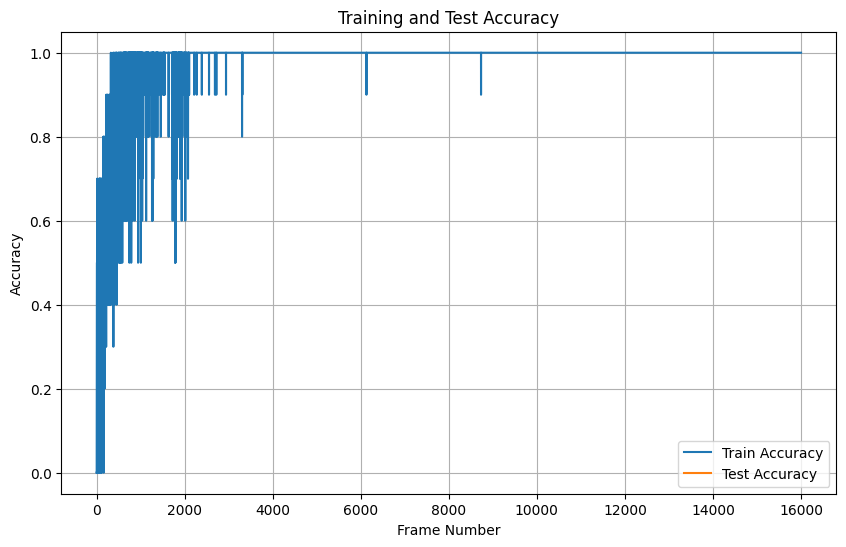

In [28]:
import matplotlib.pyplot as plt

# Plot training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Frame Number')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Frame Number')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Testing

In [29]:
def test_step(datax, datay, Ns,Nc, Nq):
    Qx, Qy= protonet(datax, datay, Ns, Nc, Nq, np.unique(datay))
    pred = torch.log_softmax(Qx, dim=-1)
    loss = F.nll_loss(pred, Qy)
    acc = torch.mean((torch.argmax(pred, 1) == Qy).float())
    return loss, acc

In [30]:
num_test_episode = 2000

In [31]:
avg_loss = 0
avg_acc = 0
for _ in range(num_test_episode):
    loss, acc = test_step(testx, testy, 5, 2, 5)
    avg_loss += loss.data
    avg_acc += acc.data
print('Avg Loss: ', avg_loss.data.cpu().numpy().tolist() / num_test_episode , 'Avg Accuracy:', (avg_acc.data.cpu().numpy().tolist() * 100) / num_test_episode)

Avg Loss:  2.61387744140625 Avg Accuracy: 60.87471313476563
